In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy import create_engine, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
# Declare base using 'automap_base()'
Base = automap_base()


# Use the Base class to reflect the database tables

Base.prepare(autoload_with=engine)


In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table

# Map the Measurment Class 
measurement=Base.classes.measurement

# Map the station Class
station=Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
#find list of columns in the measurement table
inspector = inspect(engine)
inspector.get_table_names()  

#Get a list of the column names and types in measurements
columns=inspector.get_columns('measurement')
for c in columns:
    print(c['name'],c['type'])

#columns in Measurement table

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [10]:
#find list of columns in the station table
inspector = inspect(engine)
inspector.get_table_names()  

#Get a list of the column names and types in station table
columns=inspector.get_columns('station')
for c in columns:
    print(c['name'],c['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [11]:
#From the above data it was determined that the date and precipitation
#come from the measurments table.

In [12]:
#need to figure out what the date is set as in the measurement 
engine.execute('SELECT * FROM measurement LIMIT 5').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0)]

In [13]:
# Find the most recent date in the data set.
session.query(measurement.date).order_by(measurement.date.desc()).first()


('2017-08-23',)

In [14]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database.
# Calculate the date one year from the last date in data set.
# Perform a query to retrieve the data and precipitation scores.



for_last_year = session.query(measurement.date, measurement.prcp).\
    filter(measurement.date >= '2016-08-23').\
    order_by(measurement.date).all()



In [15]:
# Save the query results as a Pandas DataFrame. Explicitly set the column names
for_last_year_df = pd.DataFrame(for_last_year)
for_last_year_final_df = for_last_year_df.set_index("date")
for_last_year_final_df.head()


,prcp
date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,NaN
2016-08-23,0.02


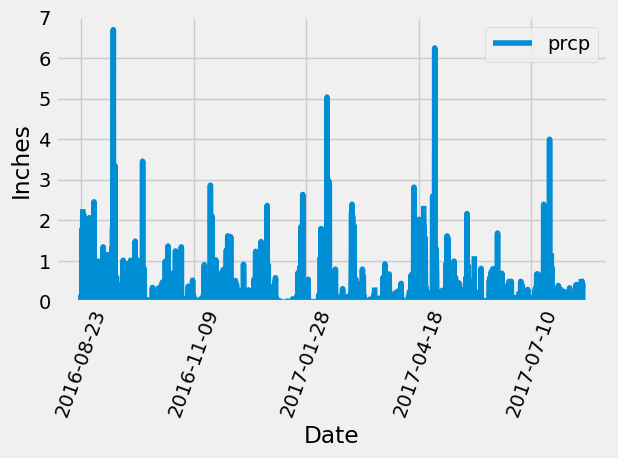

In [16]:
# Sort the dataframe by date
# Use Pandas Plotting with Matplotlib to plot the data

for_last_year_final_df.plot()
plt.ylim(0,7)
plt.xticks(rotation=70)
plt.xlabel('Date')
plt.ylabel('Inches')
plt.tight_layout()
plt.savefig("images/precipitation.png")
plt.show()


In [17]:
# Use Pandas to calculate the summary statistics for the precipitation data
for_last_year_final_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [18]:
# Design a query to calculate the total number of stations in the dataset
total_station = session.query(station.station).count()
total_station

9

In [19]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
#activity would be determined by number of measurements taken at each station


active_stations = session.query(measurement.station,func.count(measurement.station)).\
    order_by(func.count(measurement.station).desc()).\
    group_by(measurement.station).all() 

print(active_stations) 


[('USC00519281', 2772), ('USC00519397', 2724), ('USC00513117', 2709), ('USC00519523', 2669), ('USC00516128', 2612), ('USC00514830', 2202), ('USC00511918', 1979), ('USC00517948', 1372), ('USC00518838', 511)]


In [20]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
# Most active station is USC00519281 with 2772 measurements

most_active_station = session.query(measurement.station,func.count(measurement.station)).\
    order_by(func.count(measurement.station).desc()).\
    group_by(measurement.station).first()

print(most_active_station)

('USC00519281', 2772)


In [21]:
#need to isolate the station
most_active_station_number = most_active_station[0]
most_active_station_number 


'USC00519281'

In [22]:
#Lowest Temperature at USC00519281
min_temp = session.query(func.min(measurement.tobs)).\
    filter(measurement.station==most_active_station_number).all()
print(min_temp)


[(54.0,)]


In [23]:
#Highest Temperature at USC00519281
max_temp = session.query(func.max(measurement.tobs)).\
    filter(measurement.station==most_active_station_number).all()
print(max_temp)

[(85.0,)]


In [24]:
#Averate Temperature at USC00519281
avg_temp = session.query(func.avg(measurement.tobs)).\
    filter(measurement.station==most_active_station_number).all()
print(avg_temp)

[(71.66378066378067,)]


In [25]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
#Most recent data for USC00519281

active_station_data = session.query(measurement.date,measurement.tobs).\
    filter(measurement.station == most_active_station_number).\
    order_by(measurement.date.desc()).first()

active_station_data


('2017-08-18', 79.0)

In [26]:
#last 12 months of data (2016-08-18 to 2017-08-18)

for_last_year2 = session.query(measurement.date, measurement.tobs).\
    filter(measurement.station == most_active_station_number).\
    filter(measurement.date >= '2016-08-18').\
    order_by(measurement.date).all()



In [27]:
#make dataframe of for_last_year_2 query
for_last_year2_df = pd.DataFrame(for_last_year2)
for_last_year2_df
   


,date,tobs
0,2016-08-18,80.0
1,2016-08-19,79.0
2,2016-08-20,81.0
3,2016-08-21,79.0
4,2016-08-22,78.0
...,...,...
352,2017-08-14,77.0
353,2017-08-15,77.0
354,2017-08-16,76.0
355,2017-08-17,76.0


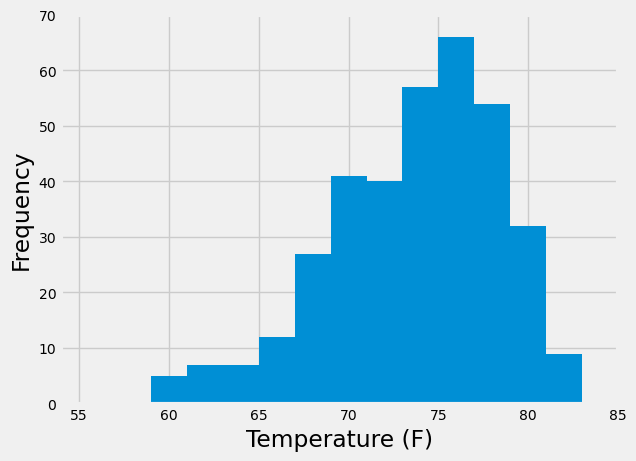

In [28]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

hist = for_last_year2_df.hist(bins=12) 
plt.title('')
plt.xlabel('Temperature (F)')
plt.ylabel('Frequency')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlim(54,85)
plt.ylim(0,70)
plt.tight_layout()
plt.savefig("images/tobs.png")
plt.show()


# Close Session

In [29]:
# Close Session
session.close()